<h1 align="center"><font color="blue">SABER Model</font></h1>
<h4>Created by Issame SARROUKH</h4>

<font color="red">Remark:</font> The different parts can be run independently

<small><font color='green'>Python 3 notebook</font></small>

#### 1. Testing the quality of the calibration

In [1]:
# importing useful librairies 
import pandas as pd 
import matplotlib.pyplot as plt 

# useful function 
# change expiry and tenor time format 
def time_format(time): 
    time = (not (int(time)==0))*(str(int(time)) + 'y') + (not (int(12*(time-int(time)))==0))*(str(int(12*(time-int(time)))) + 'm')
    return time 

#lauching SABER model and calibrating the implied volatility on market data 
import SABR

In [2]:
# market data importation and transform market data into a dictionary 
mdata = pd.read_excel("market_data.xlsx", header=1)
mdata["sigma"] = mdata[[-150, -100, -50, -25, 0, 25, 50, 100, 150]].values.tolist() 
mdata.drop(columns=[-150, -100, -50, -25, 0, 25, 50, 100, 150, 'Fwd'], inplace=True)
sigmaMK_dict = mdata.set_index(["Tenor", "Expiry"]).to_dict(orient="index")

# aproximated implied voalitility importantation and transform it into a dictionary
# extracting parameter values 
outvol = pd.read_csv("outvol.csv", sep=";", header=1, index_col=False)  
outvol.drop(columns=["strikes:", " ", "Unnamed: 11"], inplace=True) 
outvol = pd.concat([mdata[["Tenor", "Expiry"]], outvol], axis=1)
outvol["sigmaAP"] = outvol[['-150', '-100', '-50', '-25', 'ATM', '25', '50', '100','150']].values.tolist() 
outvol.drop(columns=['-150', '-100', '-50', '-25', 'ATM', '25', '50', '100','150'], inplace=True)
sigmaAP_dict = outvol.set_index(["Tenor", "Expiry"]).to_dict(orient="index")

# get calibration parameters 
params = pd.read_csv("parameters.csv", sep=";", header=1, index_col=False)  
params.drop(columns=["tenor", "expiry"], inplace=True) 
params = pd.concat([mdata[["Tenor", "Expiry"]], params], axis=1)
params = params[["Tenor", "Expiry", "alpha", "beta", "rho", "nu"]]
params_dict = params.set_index(["Tenor", "Expiry"]).to_dict(orient="index")


In [3]:
#useful functions 

# change expiry and tenor time format 
def time_format(time): 
    time = (not (int(time)==0))*(str(int(time)) + 'y') + (not (int(12*(time-int(time)))==0))*(str(int(12*(time-int(time)))) + 'm')
    return time 

# plot calibrated smiles for a tenor and an expiry 
def plot_calibrated_smile(tenor, expiry, ax=None):
    assert ax is not None 
    if ax is not None: 
        plt=ax 
    """
    param_range: is a tuple with two items, first: name of the parameter
    second: a list of possible values 
    """
    K = [-150, -100, -50, -25, 0, 25, 50, 100, 150]
    plt.plot(K,  sigmaAP_dict[(tenor, expiry)]["sigmaAP"]) 
    plt.scatter(K, sigmaMK_dict[(tenor, expiry)]["sigma"], color='r')
    plt.set_title(f'Calibrated smile with parameters '+ "\n" + 
                  " ".join(map(lambda x: "$\\{name}$ = {value:.2f} ".format(name=x[0], value=x[1]), params_dict[(tenor, expiry)].items()))+
             "\n"+(' tenor=%s'%time_format(tenor)) + (' expiry=%s '%time_format(expiry)))
    plt.set_xlabel("Strike spread") 
    plt.set_ylabel("Implied volatility")
    plt.legend(["SABER model", "Market"]) 
    
# plot calibrated smile for 4 tenors and expiries 
def plot_calibrated_smiles(tenors, expiries): 
    assert len(tenors)   == 4
    assert len(expiries) == 4
    fig, axes = plt.subplots(2, 2, figsize=(18,18))
    for index, (tenor, expiry) in enumerate(zip(tenors, expiries)):
        plot_calibrated_smile(tenor, expiry, axes[index//2, index%2])

In [4]:
# parameters 
tenors = [5, 10, 15, 30]
expiries = [0.75, 10, 2, 1]

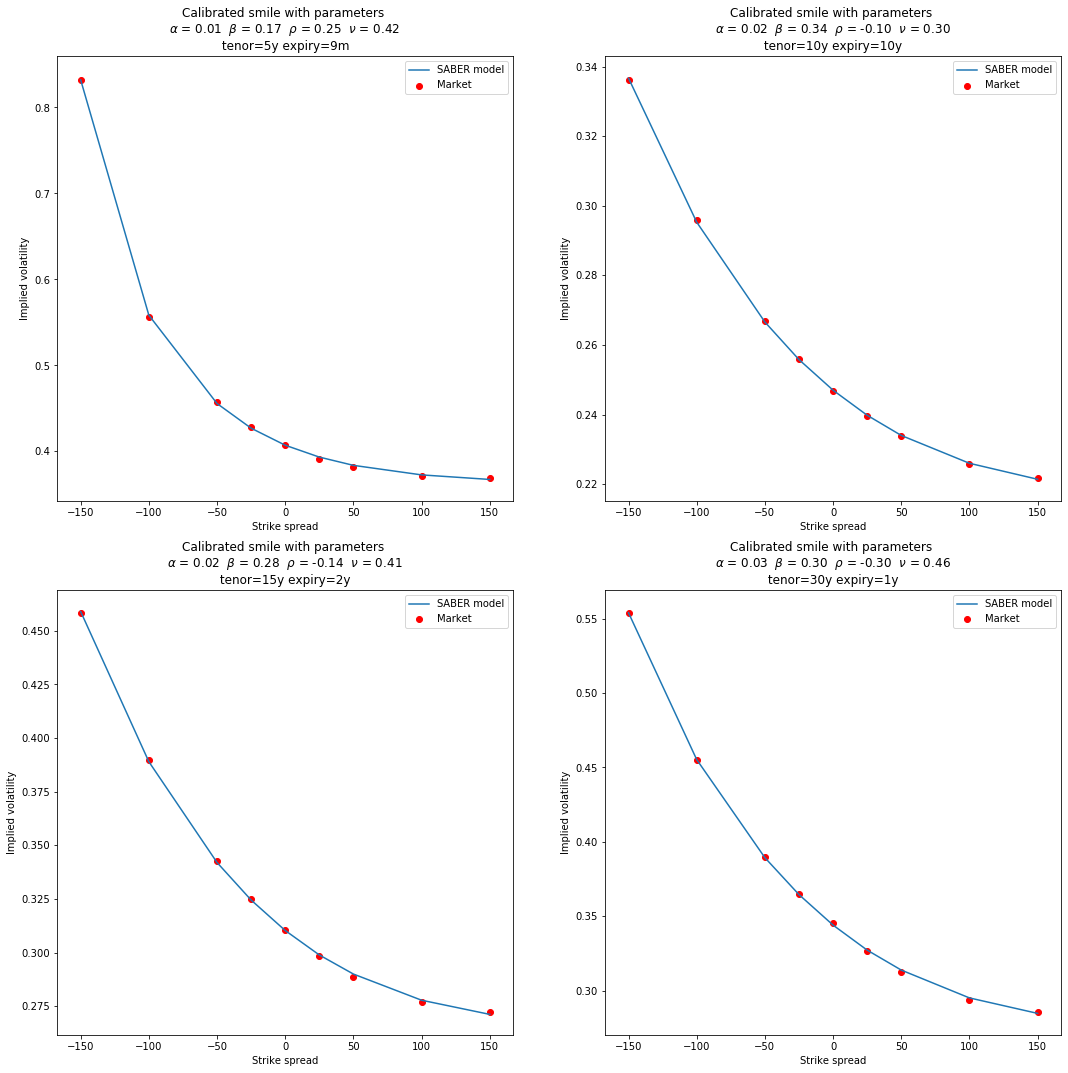

In [5]:
# calibrated smiles plot 
plot_calibrated_smiles(tenors, expiries)

#### 2. Compare the influence of the preset $\beta$ value on the quality of the adjustment on market data

In [13]:
# some useful libraries 
import pandas as pd 
import matplotlib.pyplot as plt 

# custom function to set a fix a parameter before fitting saber model 
from SABR_market import launch_sabr

In [14]:
# market data importation and transform market data into a dictionary 
mdata = pd.read_excel("market_data.xlsx", header=1)
mdata["sigma"] = mdata[[-150, -100, -50, -25, 0, 25, 50, 100, 150]].values.tolist() 
mdata.drop(columns=[-150, -100, -50, -25, 0, 25, 50, 100, 150, 'Fwd'], inplace=True)
sigmaMK_dict = mdata.set_index(["Tenor", "Expiry"]).to_dict(orient="index")

In [15]:
# function that returns new implied volatility after fiting the parameters 
def sigmaApp(tenor, expiry, param): 
    
    """
    param: a tuple with two items, first: name of the parameter 
    second: value of the parameter 
    """
    launch_sabr(param) 
    outvol = pd.read_csv("outvol.csv", sep=";", header=1, index_col=False)   
    outvol.drop(columns=["strikes:", " ", "Unnamed: 11"], inplace=True)
    outvol['sigma'] = outvol[['-150', '-100', '-50', '-25', 'ATM', '25', '50', '100', '150']].values.tolist()
    outvol.drop(columns=['-150', '-100', '-50', '-25', 'ATM', '25', '50', '100', '150'], inplace=True) 
    outvol = pd.concat([mdata[["Tenor", "Expiry"]], outvol], axis=1)
    sigmaApp_dict = outvol.set_index(["Tenor", "Expiry"]).to_dict(orient="index")
    return sigmaApp_dict[(tenor, expiry)]["sigma"] 

# change expiry and tenor time format 
def time_format(time): 
    time = (not (int(time)==0))*(str(int(time)) + 'y') + (not (int(12*(time-int(time)))==0))*(str(int(12*(time-int(time)))) + 'm')
    return time 

In [16]:
# Plot market smile for different strike spreads refited each time 
# parameter names that can be chosen: beta, alpha, nu, rho
def plot_Msmile(tenor, expiry, param_range, ax=None): 
    """
    param_range: is a tuple with two items, first: name of the parameter
    second: a list of possible values 
    """
    assert ax is not None 
    if ax is not None: 
        plt=ax 
    K = [-150, -100, -50, -25, 0, 25, 50, 100, 150]
    plt.scatter(K, sigmaMK_dict[(tenor, expiry)]["sigma"], c='red')   
    param_name = param_range[0]
    for value in param_range[1]: 
        param = (param_range[0], value)
        sigma = sigmaApp(tenor, expiry, param) 
        plt.plot(K,  sigma) 

    plt.set_title(f'refited smile for $\\{param_name}$ equal to '+" and ".join(map(str, param_range[1]))+
             (' tenor=%s'%time_format(tenor)) + (' expiry=%s '%time_format(expiry)))
    plt.set_xlabel("Strike spread") 
    plt.set_ylabel("Implied volatility")
    plt.legend(list(map(lambda s: f"$\\{param_name}$={s}", param_range[1])) + ["implied market voaltility"])

# Plot market smile for different strike spreads refited each time 
def plot_Msmiles(tenors, expiries, param_range): 
    assert len(tenors)   == 4
    assert len(expiries) == 4
    fig, axes = plt.subplots(2, 2, figsize=(18,18))
    for index, (tenor, expiry) in enumerate(zip(tenors, expiries)):
        plot_Msmile(tenor, expiry, param_range, axes[index//2, index%2])

In [17]:
# parameters 
tenors = [5, 10, 15, 30]
expiries = [0.75, 10, 2, 1]

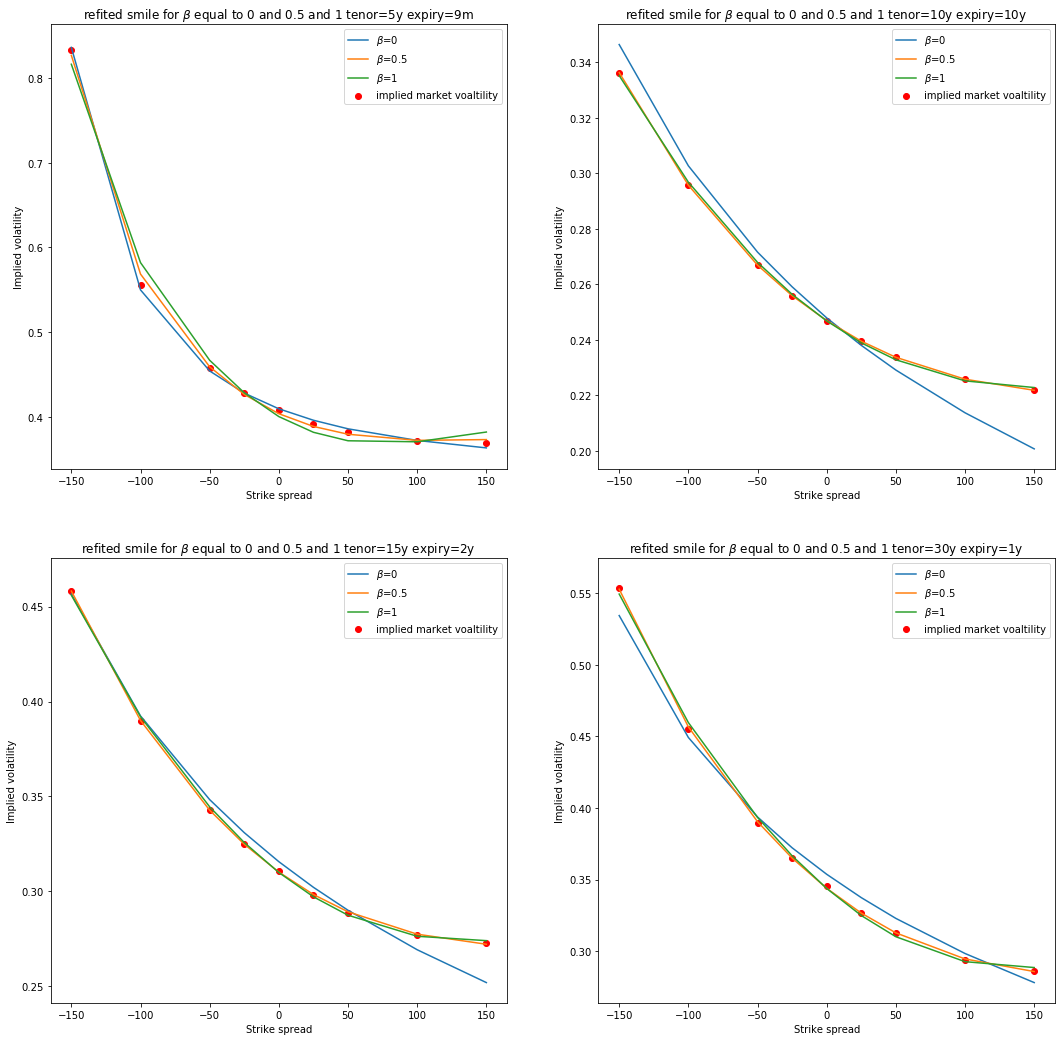

In [18]:
# I am only going to talk about beta hower this function is usable for other paameters see the cell after
plot_Msmiles(tenors, expiries, ("beta", [0, 0.5, 1])) 

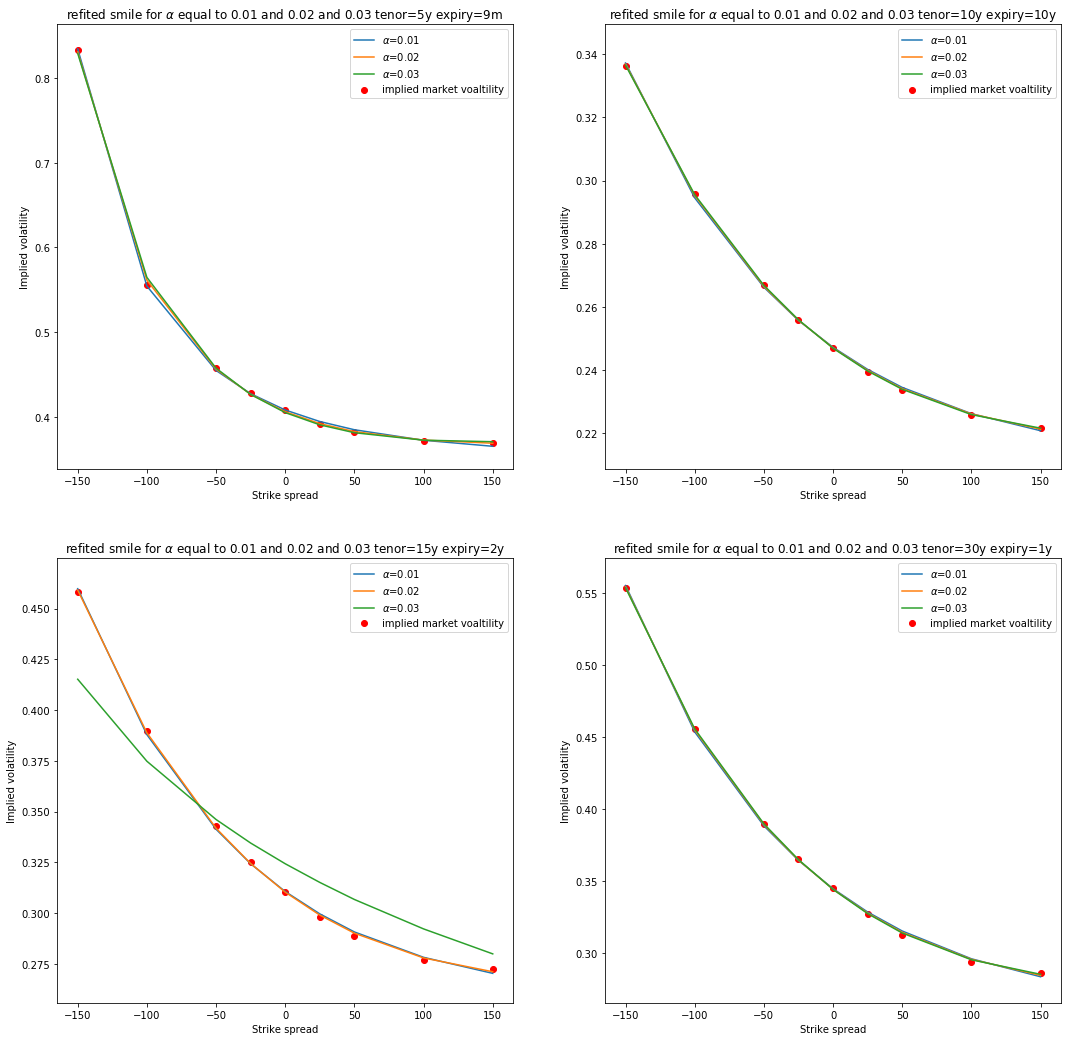

In [12]:
plot_Msmiles(tenors, expiries, ("alpha", [0.01, 0.02, 0.03])) 

#### 3. Adjust the SABR model once, and then change the parameters to evaluate their effect

In [1]:
# importing useful librairies 
import pandas as pd 
import matplotlib.pyplot as plt 

# useful function 
# change expiry and tenor time format 
def time_format(time): 
    time = (not (int(time)==0))*(str(int(time)) + 'y') + (not (int(12*(time-int(time)))==0))*(str(int(12*(time-int(time)))) + 'm')
    return time 

In [2]:
# importing market data
mdata = pd.read_excel("market_data.xlsx", header=1)

In [3]:
#lauching SABER model and calibrating the implied volatility on market data 
import importlib
import SABR
importlib.reload(SABR)  

# importing custom smile function 
from utils import smile

In [4]:
# extracting parameter values 
params = pd.read_csv("parameters.csv", sep=";", header=1, index_col=False)  
params.drop(columns=["tenor", "expiry"], inplace=True) 
params = pd.concat([mdata[["Tenor", "Expiry", "Fwd"]], params], axis=1)
params = params[["Tenor", "Expiry", "alpha", "beta", "rho", "nu", "Fwd"]]

In [5]:
# change parameters to dictionary 
params_dict = params.set_index(["Tenor", "Expiry"]).to_dict(orient="index")

In [6]:
# plot smile for different values of a parameter after one time fitting to market data
def plot_smile(tenor, expiry, param_range, ax=None):
    if ax is not None: 
        plt=ax 
    """
    param_range: is a tuple with two items, first: name of the parameter
    second: a list of possible values 
    """    
    K = [-150, -100, -50, -25, 0, 25, 50, 100, 150]
    parameters = params_dict[(tenor, expiry)].copy()
    time = expiry
    param_name = param_range[0]

    for value in param_range[1]: 
        
        parameters[param_name] = value 
        
        vols = smile(*parameters.values() ,K, time)
   
        plt.plot(K, vols) 
    plt.set_title(f'plot smile for different values of $\\{param_name}$'+
             (' tenor=%s'%time_format(tenor)) + (' expiry=%s '%time_format(expiry)))
    plt.set_xlabel("Strike spread") 
    plt.set_ylabel("SABER volatility")
    plt.legend(list(map(lambda s: f"$\\{param_name}$ = {s}", param_range[1]))) 

# plot calibrated smile for 4 tenors and expiries 
def plot_smiles(tenors, expiries, param_range): 
    assert len(tenors)   == 4
    assert len(expiries) == 4
    fig, axes = plt.subplots(2, 2, figsize=(15,15))
    for index, (tenor, expiry) in enumerate(zip(tenors, expiries)):
        plot_smile(tenor, expiry, param_range, axes[index//2, index%2])

In [7]:
# parameters 
tenors = [5, 10, 15, 30]
expiries = [0.75, 10, 2, 1]

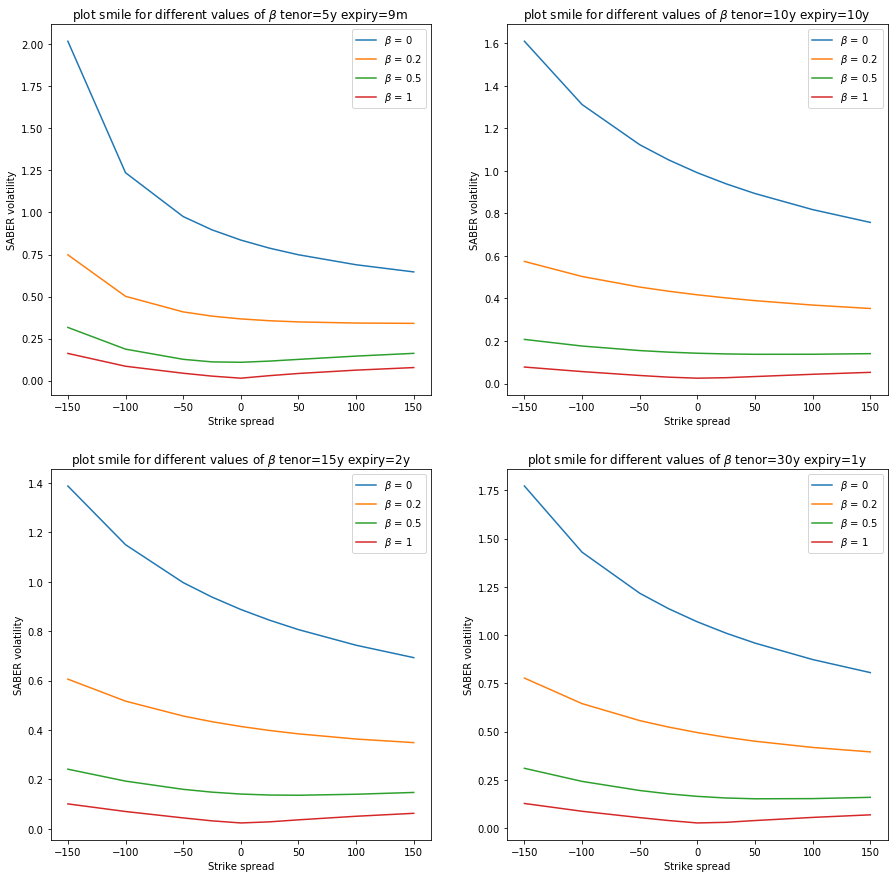

In [8]:
plot_smiles(tenors, expiries, ("beta", [0, 0.2, 0.5, 1])) 

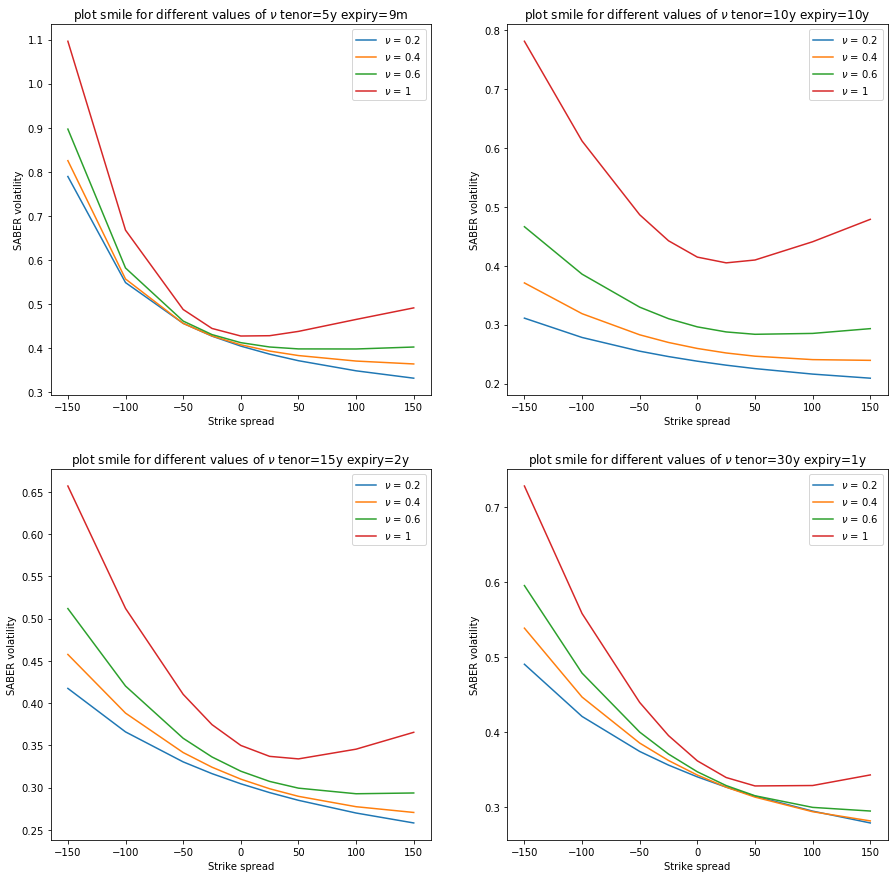

In [9]:
plot_smiles(tenors, expiries, ("nu", [0.2, 0.4, 0.6, 1])) 

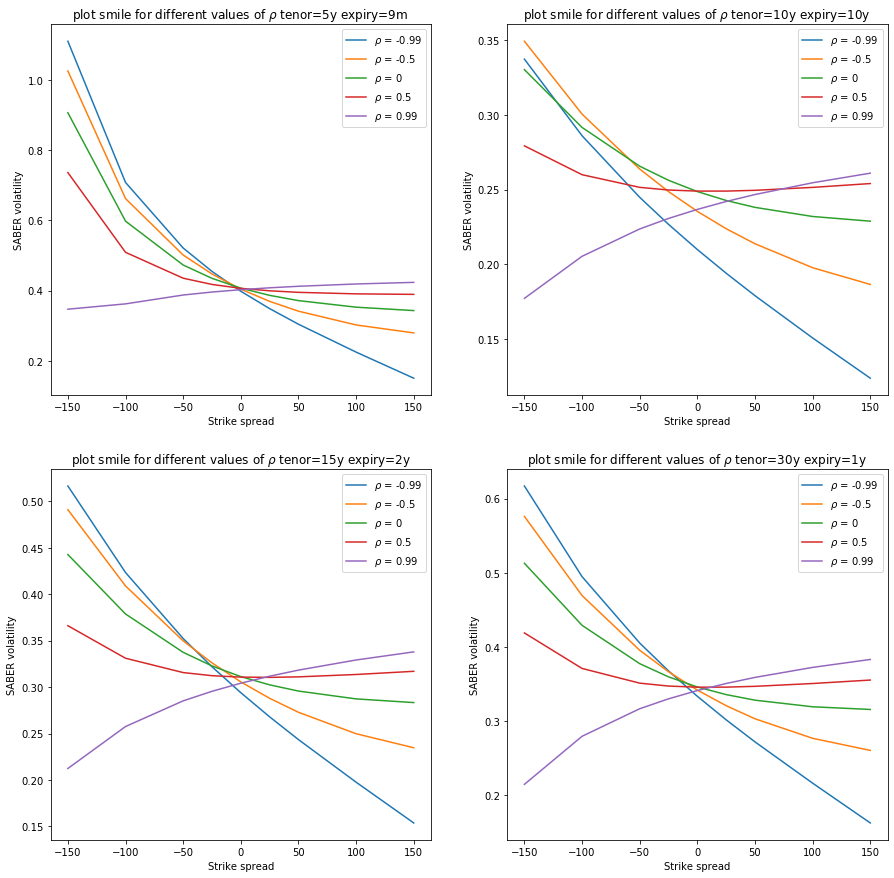

In [10]:
plot_smiles(tenors, expiries, ("rho", [-0.99, -0.5, 0, 0.5, 0.99])) 

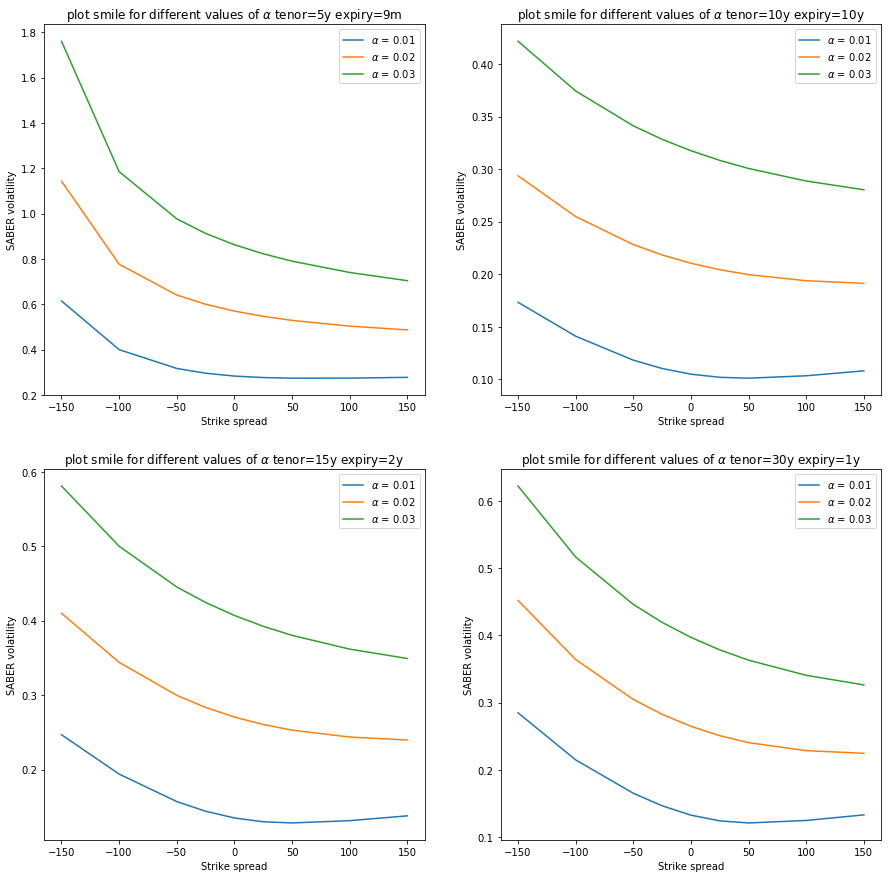

In [11]:
plot_smiles(tenors, expiries, ("alpha", [0.01, 0.02, 0.03])) 